# Test 3 - Convergence FEM / PINNs+Corr

In [1]:
# sélection du cas test
testcase = 3 
version = 1
param_num = 2

**Idée :** On se place ici dans un des cas tests proposés.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modules.utils import create_tree

from modules.geometry import Square
from modules.fenics_expressions_3 import FExpr,AnisotropyExpr

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


In [4]:
if testcase == 1:
    if version == 1:
        from modules.testcases.test_1 import Run_laplacian2D,Poisson_2D
    elif version == 2:
        from modules.testcases.test_1_v2 import Run_laplacian2D,Poisson_2D
    else:
        raise ValueError("Version not found")
    from modules.problem import TestCase1
    from modules.solver_fem import FEMSolver
    problem = TestCase1()
elif testcase == 2:
    from modules.testcases.test_2 import Run_laplacian2D,Poisson_2D
    from modules.problem import TestCase2
    from modules.solver_fem import FEMSolver
    problem = TestCase2()
elif testcase == 3:
    from modules.testcases.test_3 import Run_laplacian2D,Poisson_2D
    from modules.problem import TestCase3
    from modules.solver_fem_3 import FEMSolver
    problem = TestCase3()
else:
    raise ValueError("Testcase not found")

result_dir = "../results/testcase"+str(testcase)
if version != 1:
    result_dir += "_v"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

torch loaded; device is cuda


>> load network /home/flecourtier/Bureau/Article1/networks/test_fe3.pth
jsbdbshd
network loaded


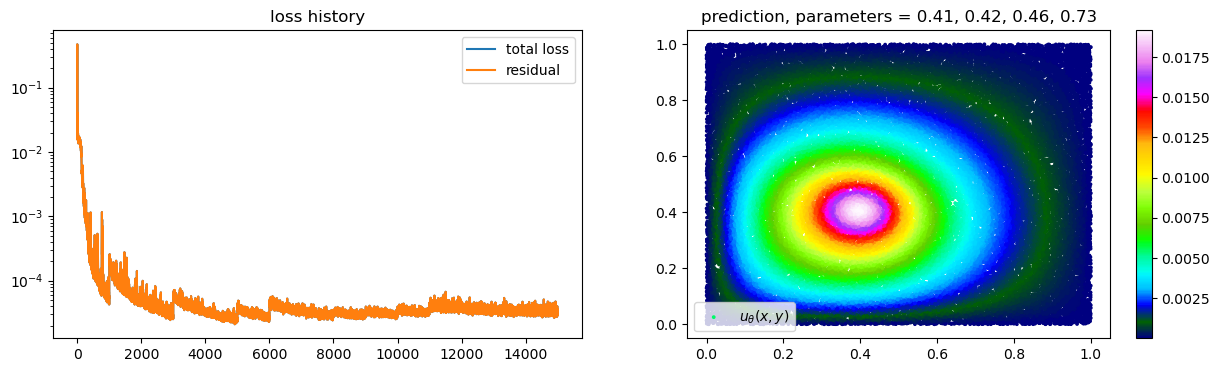

In [5]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [6]:
def get_param(i):
    parameter_domain = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(params[k][0], params[k][1]))
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.48 0.53 0.41 0.89]


## Solution de référence

In [7]:
def create_ref_domain(deg):
    nb_vert = 600

    # check if pb_considered is instance of Square class
    if isinstance(problem.geometry, Square):
        box = np.array(problem.geometry.box)
        mesh_ref = df.RectangleMesh(df.Point(box[0,0], box[1,0]), df.Point(box[0,1], box[1,1]), nb_vert - 1, nb_vert - 1)
    else:
        raise ValueError("Geometry not implemented")
    
    V_ref = df.FunctionSpace(mesh_ref, "CG", deg)
    dx_ref = df.Measure("dx", domain=mesh_ref)
    
    h_ref = mesh_ref.hmax()
    print("hmax = ",h_ref)

    return mesh_ref, V_ref, dx_ref
    
def get_uref(param,deg):
    mesh_ref, V_ref, dx_ref = create_ref_domain(deg)
    boundary = "on_boundary"

    mat = AnisotropyExpr(param, degree=10, domain=mesh_ref, pb_considered=problem) 
    # mat = df.Expression((("eps * x[0]*x[0] + x[1]*x[1]","(eps - 1) * x[0] * x[1]"),
    #                 ("(eps - 1) * x[0] * x[1]","x[0]*x[0] + eps * x[1]*x[1]")), 
    #                 eps=param[3],
    #                 degree=10, 
    #                 domain=mesh_ref)
    
    f_expr = FExpr(param, degree=10, domain=mesh_ref, pb_considered=problem)
    
    g = df.Constant("0.0")
    bc = df.DirichletBC(V_ref, g, boundary)

    u = df.TrialFunction(V_ref)
    v = df.TestFunction(V_ref)
    
    # Resolution of the variationnal problem

    a = df.inner(mat*df.grad(u),df.grad(v)) * dx_ref
    l = f_expr * v * dx_ref

    sol = df.Function(V_ref)
    df.solve(a==l, sol, bcs=bc)

    return sol

u_ref = get_uref(param,deg=2)


hmax =  0.002360957533177268
Solving linear variational problem.


## Convergence FEM

In [8]:
def read_csv(testcase,param_num,degree):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    df_FEM = pd.read_csv(csv_file)
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        print("Run FEM")
        tab_nb_vert_FEM = [2**i for i in range(4,9)]
        tab_h_FEM = []
        tab_err_FEM = []

        for nb_vert in tab_nb_vert_FEM:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_FEM.append(solver.h)
            _,norme_L2 = solver.fem(0,u_ref)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_FEM.append(norme_L2)
            
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

In [9]:
# degree = 3
# df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(degree)

degree=1
Run FEM
hmax =  0.09428090415820647
nb_vert=16, norme_L2=0.032841057109698174
hmax =  0.045619792334616084
nb_vert=32, norme_L2=0.008507695232567732
hmax =  0.02244783432338254
nb_vert=64, norme_L2=0.002116250943187895
hmax =  0.01113553986120561
nb_vert=128, norme_L2=0.0005243344638097781
hmax =  0.005545935538718157
nb_vert=256, norme_L2=0.00013028001897857837
degree=2
Run FEM
hmax =  0.09428090415820647
nb_vert=16, norme_L2=0.0024679356219990726
hmax =  0.045619792334616084
nb_vert=32, norme_L2=0.00028298714520853867
hmax =  0.02244783432338254
nb_vert=64, norme_L2=3.4126718790791805e-05
hmax =  0.01113553986120561
nb_vert=128, norme_L2=4.2302606471256625e-06
hmax =  0.005545935538718157
nb_vert=256, norme_L2=5.368619163810004e-07
degree=3
Run FEM
hmax =  0.09428090415820647
nb_vert=16, norme_L2=0.00030721438324874105
hmax =  0.045619792334616084
nb_vert=32, norme_L2=1.8170197338023113e-05
hmax =  0.02244783432338254
nb_vert=64, norme_L2=1.3483727783236178e-06
hmax =  0.011

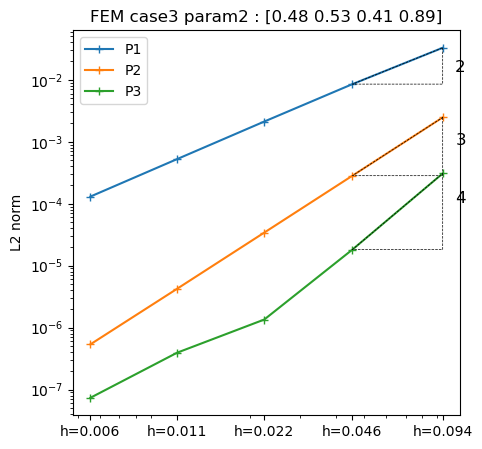

In [10]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['h'], df_FEM['err'], "+-", label='P'+str(d))
    
    # add slope with a triangle
    start = [tab_h_FEM[1],tab_err_FEM[1]]
    end = [tab_h_FEM[0],tab_err_FEM[0]]
    third = [end[0],start[1]]
    
    tri_x = [end[0], third[0], start[0], end[0]]
    tri_y = [end[1], third[1], start[1], end[1]]
    plt.plot(tri_x, tri_y, "k--", linewidth=0.5)
    
    slope = (np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    slope = int(slope.round(0))

    vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')
    
plt.xticks(df_FEM['h'], "h="+df_FEM['h'].round(3).astype(str))
plt.ylabel('L2 norm')
plt.title(f'FEM case{testcase} param{param_num} : {param}')
plt.legend()
plt.savefig(result_dir+f'FEM_case{testcase}_param{param_num}.png')

In [11]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, _, tab_h_FEM, tab_err_FEM = run_FEM(d)
    if d == 1:
        dict['h'] = tab_h_FEM
    dict[f'P{d}'] = tab_err_FEM
    
df_deg = pd.DataFrame(dict)

csv_file = result_dir+f'FEM_case{testcase}_param{param_num}.csv'
df_deg.to_csv(csv_file, index=False)

degree=1
Read csv file ../results/testcase3/cvg/FEM_case3_param2_degree1.csv
degree=2
Read csv file ../results/testcase3/cvg/FEM_case3_param2_degree2.csv
degree=3
Read csv file ../results/testcase3/cvg/FEM_case3_param2_degree3.csv


## Convergence PINNs+Corr

In [12]:
def get_test_sample(solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    if shape[1] == 0:
        mu_test = torch.zeros(shape)
    else:
        ones = torch.ones(shape)
        mu_test = (torch.mean(trainer.pde.parameter_domain, axis=1) * ones)#.to(device)

    return V_test,X_test,mu_test

In [13]:
degree_PINNs = 10

def read_csv_Corr(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

def run_Corr(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = read_csv_Corr(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Corr = [5*i for i in range(2,7)]
        tab_h_Corr = []
        tab_err_Corr = []

        for nb_vert in tab_nb_vert_Corr:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_Corr.append(solver.h)
            
            V_test,X_test,mu_test = get_test_sample(solver,trainer,degree_PINNs)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
            u_PINNs = df.Function(V_test)
            u_PINNs.vector()[:] = phi_tild.copy()
            
            _,_,norme_L2 = solver.corr_add(0,u_PINNs,u_ref)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            
        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

degree=1
hmax =  0.1571348402636773
nb_vert=10, norme_L2=0.07236371523952606
hmax =  0.10101525445522119
nb_vert=15, norme_L2=0.034065705561305434
hmax =  0.07443229275647877
nb_vert=20, norme_L2=0.019590444575051522
hmax =  0.058925565098879064
nb_vert=25, norme_L2=0.012645764296052681
hmax =  0.048765984909417165
nb_vert=30, norme_L2=0.008803363618705023
degree=2
hmax =  0.1571348402636773
nb_vert=10, norme_L2=0.009145984686071
hmax =  0.10101525445522119
nb_vert=15, norme_L2=0.002544181445305292
hmax =  0.07443229275647877
nb_vert=20, norme_L2=0.0010573369463846801
hmax =  0.058925565098879064
nb_vert=25, norme_L2=0.0005286801395805042
hmax =  0.048765984909417165
nb_vert=30, norme_L2=0.0003015787388526532
degree=3
hmax =  0.1571348402636773
nb_vert=10, norme_L2=0.0018248469532980956
hmax =  0.10101525445522119
nb_vert=15, norme_L2=0.0003608363853979003
hmax =  0.07443229275647877
nb_vert=20, norme_L2=0.00010527107551399338
hmax =  0.058925565098879064
nb_vert=25, norme_L2=4.2160553

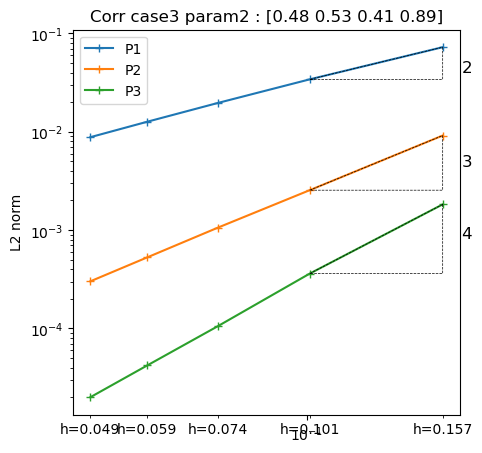

In [14]:
plt.figure(figsize=(5, 5))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['h'], df_Corr['err'], "+-", label='P'+str(d))
    
    # add slope with a triangle
    start = [tab_h_Corr[1],tab_err_Corr[1]]
    end = [tab_h_Corr[0],tab_err_Corr[0]]
    third = [end[0],start[1]]
    
    tri_x = [end[0], third[0], start[0], end[0]]
    tri_y = [end[1], third[1], start[1], end[1]]
    plt.plot(tri_x, tri_y, "k--", linewidth=0.5)
    
    slope = (np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    slope = int(slope.round(0))

    vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')

plt.xticks(df_Corr['h'], "h="+df_Corr['h'].round(3).astype(str), minor=True)
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'Corr_case{testcase}_param{param_num}.png')

In [15]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, _, tab_h_Corr, tab_err_Corr = run_Corr(d)
    if d == 1:
        dict['h'] = tab_h_Corr
    dict[f'P{d}'] = tab_err_Corr
    
df_deg_Corr = pd.DataFrame(dict)

csv_file = result_dir+f'Corr_case{testcase}_param{param_num}.csv'
df_deg_Corr.to_csv(csv_file, index=False)

degree=1
Read csv file ../results/testcase3/cvg/Corr_case3_param2_degree1.csv
degree=2
Read csv file ../results/testcase3/cvg/Corr_case3_param2_degree2.csv
degree=3
Read csv file ../results/testcase3/cvg/Corr_case3_param2_degree3.csv


## Plots

degree=1
Read csv file ../results/testcase3/cvg/FEM_case3_param2_degree1.csv
degree=2
Read csv file ../results/testcase3/cvg/FEM_case3_param2_degree2.csv
degree=3
Read csv file ../results/testcase3/cvg/FEM_case3_param2_degree3.csv
degree=1
Read csv file ../results/testcase3/cvg/Corr_case3_param2_degree1.csv
degree=2
Read csv file ../results/testcase3/cvg/Corr_case3_param2_degree2.csv
degree=3
Read csv file ../results/testcase3/cvg/Corr_case3_param2_degree3.csv


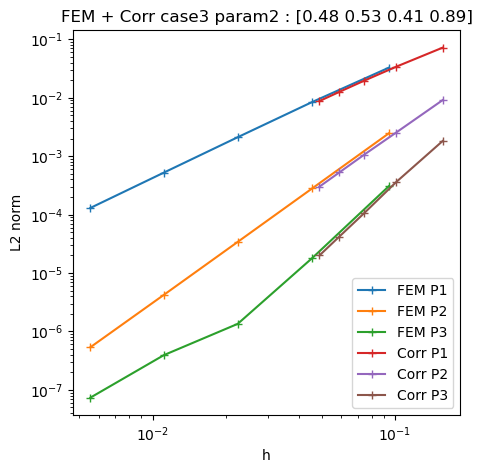

In [16]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['h'], df_FEM['err'], "+-", label='FEM P'+str(d))
    
    # add slope with a triangle
    # start = [tab_h_FEM[1],tab_err_FEM[1]]
    # end = [tab_h_FEM[0],tab_err_FEM[0]]
    # third = [end[0],start[1]]
    
    # tri_x = [end[0], third[0], start[0], end[0]]
    # tri_y = [end[1], third[1], start[1], end[1]]
    # plt.plot(tri_x, tri_y, "k--", linewidth=0.5)
    
    # slope = (np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    # slope = int(slope.round(0))

    # vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    # plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['h'], df_Corr['err'], "+-", label='Corr P'+str(d))
    
    # add slope with a triangle
    # start = [tab_h_Corr[1],tab_err_Corr[1]]
    # end = [tab_h_Corr[0],tab_err_Corr[0]]
    # third = [end[0],start[1]]
    
    # tri_x = [end[0], third[0], start[0], end[0]]
    # tri_y = [end[1], third[1], start[1], end[1]]
    # plt.plot(tri_x, tri_y, "k--", linewidth=0.5)
    
    # slope = (np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    # slope = int(slope.round(0))

    # vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    # plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')

plt.xlabel("h")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'FEM + Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'FEM-Corr_case{testcase}_param{param_num}.png')